<a href="https://colab.research.google.com/github/Pranav97Tyagi/linear-regression/blob/master/Roof__Type_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root_dir = "/content/drive/My Drive/Colab Notebooks/"
csv_file = os.path.join(root_dir, "roof_type_labels.csv")  # labeled data
image_dir = os.path.join(root_dir, "images")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_sz = 32
n_classes = 5            # Number of classes
k_folds = 5            # Number of folds
epochs = 4           # Epochs per fold

In [3]:
class RoofImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        # Read CSV and drop rows with missing filenames
        self.data = pd.read_csv(csv_path).dropna(subset=[pd.read_csv(csv_path).columns[0]])
        self.img_dir = img_dir
        self.transform = transform

        # label mapping from CSV data
        self.label_set = sorted(self.data['label'].unique())
        self.label_to_index = {name: i for i, name in enumerate(self.label_set)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        fname = str(self.data.iloc[index, 0])
        filepath = os.path.join(self.img_dir, fname)
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")
        label = self.data.iloc[index, 1]
        label_index = self.label_to_index[label]
        image = Image.open(filepath).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_index


In [4]:
# Image Transformations
image_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

'''  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])'''
# Load Dataset

dataset = RoofImageDataset(csv_file, image_dir, transform=image_transforms)

# Create numeric target array
df = pd.read_csv(csv_file).dropna(subset=[pd.read_csv(csv_file).columns[0]])

# Map each label to an index
label_names = sorted(df['label'].unique())
name_to_idx = {name: i for i, name in enumerate(label_names)}
y_numeric = df['label'].map(name_to_idx).values


In [5]:
!pip install -q efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

# Load a pretrained EfficientNet model (B3 in this example)
model = EfficientNet.from_pretrained('efficientnet-b3')

# Replace the classifier layer. Assuming you have 6 classes:
in_features = model._fc.in_features
model._fc = torch.nn.Linear(in_features, 5)

model = model.to(device)


Loaded pretrained weights for efficientnet-b3



**** Fold 1/5 ****
Fold 1, Epoch 1: Train Loss = 1.5239, Train Acc = 30.6250
Fold 1, Epoch 2: Train Loss = 1.1830, Train Acc = 62.1875
Fold 1, Epoch 3: Train Loss = 0.9140, Train Acc = 69.6875
Fold 1, Epoch 4: Train Loss = 0.6419, Train Acc = 80.9375
Fold 1 Val Accuracy: 66.2500
              precision    recall  f1-score   support

Complex Roof       0.40      0.18      0.25        11
 Dormer Roof       0.00      0.00      0.00         5
   Flat Roof       0.62      0.87      0.72        15
  Gable Roof       0.73      0.73      0.73        30
    Hip Roof       0.67      0.84      0.74        19

    accuracy                           0.66        80
   macro avg       0.48      0.52      0.49        80
weighted avg       0.60      0.66      0.62        80



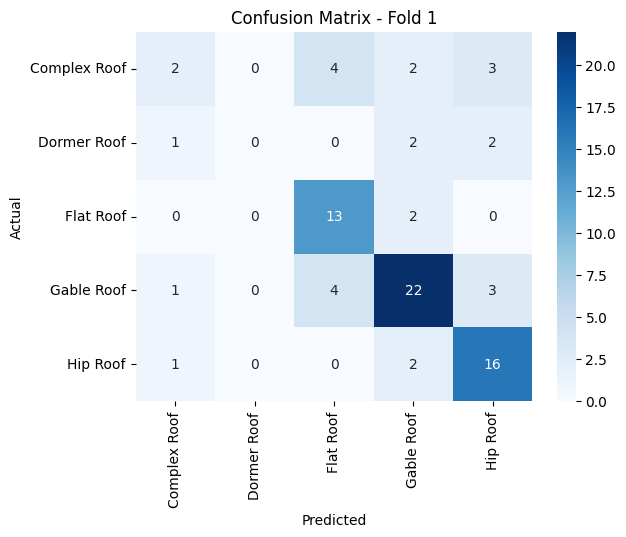


**** Fold 2/5 ****
Fold 2, Epoch 1: Train Loss = 0.6670, Train Acc = 77.1875
Fold 2, Epoch 2: Train Loss = 0.5054, Train Acc = 84.6875
Fold 2, Epoch 3: Train Loss = 0.3557, Train Acc = 90.9375
Fold 2, Epoch 4: Train Loss = 0.2514, Train Acc = 93.7500
Fold 2 Val Accuracy: 80.0000
              precision    recall  f1-score   support

Complex Roof       0.70      0.64      0.67        11
 Dormer Roof       1.00      0.40      0.57         5
   Flat Roof       0.80      0.80      0.80        15
  Gable Roof       0.79      0.90      0.84        30
    Hip Roof       0.84      0.84      0.84        19

    accuracy                           0.80        80
   macro avg       0.83      0.72      0.74        80
weighted avg       0.81      0.80      0.79        80



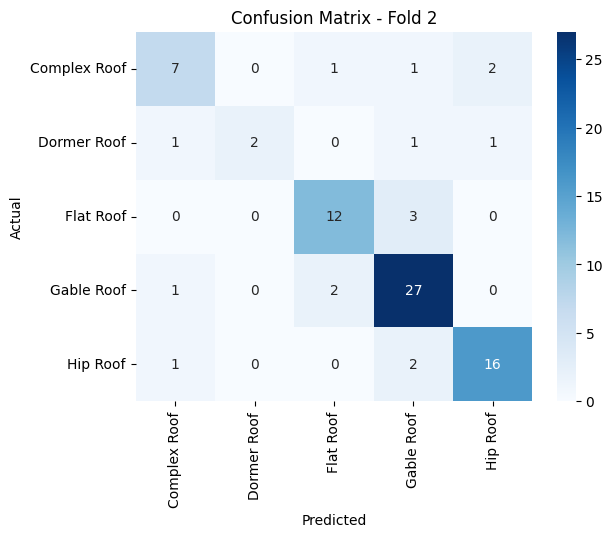


**** Fold 3/5 ****
Fold 3, Epoch 1: Train Loss = 0.2890, Train Acc = 90.3125
Fold 3, Epoch 2: Train Loss = 0.2160, Train Acc = 94.0625
Fold 3, Epoch 3: Train Loss = 0.1406, Train Acc = 96.2500
Fold 3, Epoch 4: Train Loss = 0.1315, Train Acc = 95.9375
Fold 3 Val Accuracy: 88.7500
              precision    recall  f1-score   support

Complex Roof       0.92      0.92      0.92        12
 Dormer Roof       0.67      0.40      0.50         5
   Flat Roof       1.00      0.87      0.93        15
  Gable Roof       0.88      0.97      0.92        30
    Hip Roof       0.84      0.89      0.86        18

    accuracy                           0.89        80
   macro avg       0.86      0.81      0.83        80
weighted avg       0.89      0.89      0.88        80



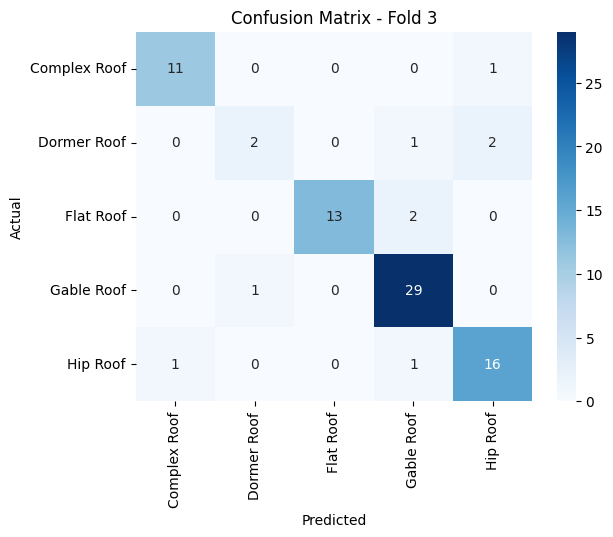


**** Fold 4/5 ****
Fold 4, Epoch 1: Train Loss = 0.2321, Train Acc = 92.8125
Fold 4, Epoch 2: Train Loss = 0.1259, Train Acc = 96.2500
Fold 4, Epoch 3: Train Loss = 0.1289, Train Acc = 96.8750
Fold 4, Epoch 4: Train Loss = 0.1103, Train Acc = 96.8750
Fold 4 Val Accuracy: 96.2500
              precision    recall  f1-score   support

Complex Roof       1.00      0.82      0.90        11
 Dormer Roof       1.00      0.83      0.91         6
   Flat Roof       1.00      1.00      1.00        15
  Gable Roof       0.97      1.00      0.98        30
    Hip Roof       0.90      1.00      0.95        18

    accuracy                           0.96        80
   macro avg       0.97      0.93      0.95        80
weighted avg       0.97      0.96      0.96        80



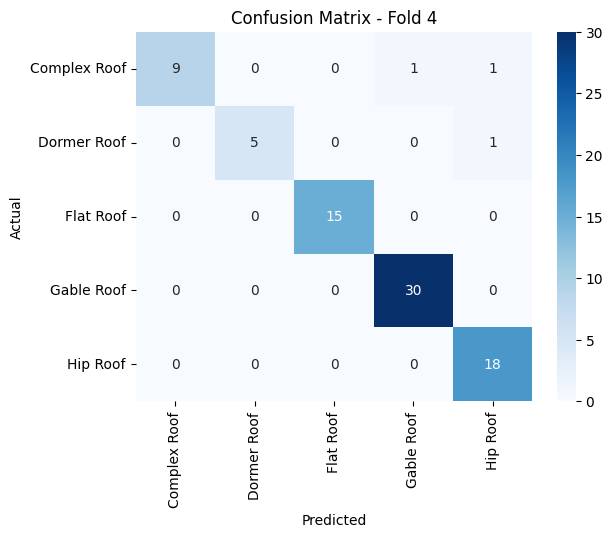


**** Fold 5/5 ****
Fold 5, Epoch 1: Train Loss = 0.1616, Train Acc = 95.0000
Fold 5, Epoch 2: Train Loss = 0.0980, Train Acc = 96.5625
Fold 5, Epoch 3: Train Loss = 0.0702, Train Acc = 97.8125
Fold 5, Epoch 4: Train Loss = 0.0588, Train Acc = 98.1250
Fold 5 Val Accuracy: 97.5000
              precision    recall  f1-score   support

Complex Roof       1.00      1.00      1.00        11
 Dormer Roof       1.00      1.00      1.00         6
   Flat Roof       1.00      0.93      0.97        15
  Gable Roof       0.94      1.00      0.97        29
    Hip Roof       1.00      0.95      0.97        19

    accuracy                           0.97        80
   macro avg       0.99      0.98      0.98        80
weighted avg       0.98      0.97      0.98        80



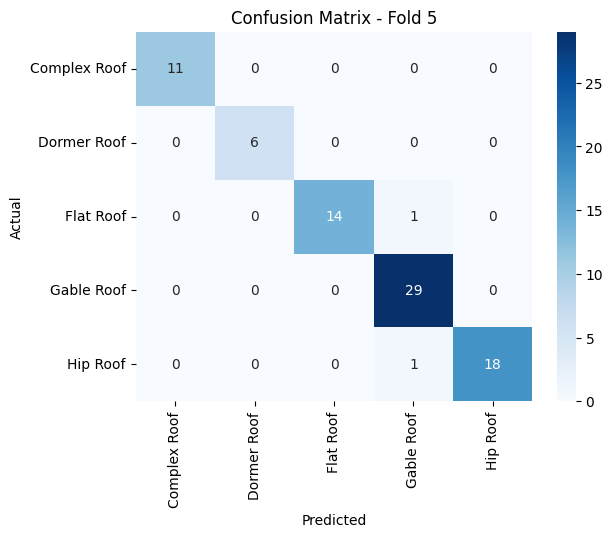


Cross Validation Results: Mean Accuracy = 0.8575, Std = 0.1158


In [6]:
# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.arange(len(dataset)), y=y_numeric)):
    print(f"\n**** Fold {fold+1}/{k_folds} ****")

    # Create training and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_sz, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_sz, shuffle=False)

    # Initialize model for ResNet-34
    #model = models.resnet34(pretrained=True)
    #model.fc = torch.nn.Linear(model.fc.in_features, n_classes)
    #model = model.to(device)

    # Loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == lbls).sum().item()
            total_samples += lbls.size(0)
        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples
        print(f"Fold {fold+1}, Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc*100:.4f}")

    # Evaluation on validation data
    model.eval()
    val_correct, val_samples = 0, 0
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == lbls).sum().item()
            val_samples += lbls.size(0)
            true_labels.extend(lbls.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    fold_accuracy = val_correct / val_samples
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Val Accuracy: {fold_accuracy*100:.4f}")
    unique_labels = sorted(set(true_labels) | set(pred_labels))

    # Create a reduced target names list
    reduced_target_names = [label_names[i] for i in unique_labels]

    # Display classification report and confusion matrix per fold
    print(classification_report(true_labels, pred_labels, target_names=reduced_target_names, zero_division=0))
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Summarize Cross Validation Performance
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"\nCross Validation Results: Mean Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")


In [8]:
# Save the trained model
model_path = os.path.join(root_dir, "roof_model.pth")
torch.save(model.state_dict(), model_path)